# t-SNE Explorations

In [1]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding
from sklearn.preprocessing import StandardScaler

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt_style = 'seaborn-talk'

# Experimental: HDBScan is a state-of-the-art clustering algorithm
hdbscan_available = True
try:
    import hdbscan
except ImportError:
    hdbscan_available = False
    
umap_available = True
try:
    import umap
except ImportError:
    umap_available = False

## Plotting function

In [2]:
def do_plot(X_fit, title=None, labels=None):
    dimension = X_fit.shape[1]
    label_types = sorted(list(set(labels)))
    num_labels = len(label_types)
    colors = cm.Accent(np.linspace(0, 1, num_labels))
    with plt.style.context(plt_style):
        fig = plt.figure()
        if dimension == 2:
            ax = fig.add_subplot(111)
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           c=[col])
        elif dimension == 3:
            ax = fig.add_subplot(111, projection='3d')
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           X_fit[labels==lab, 2],
                           c=[col])
        else:
            raise Exception('Unknown dimension: %d' % dimension)
        plt.title(title)
        plt.show()

## Generate the data
To create a simple test case, we generate some Gaussian point clouds in $\mathbb{R}^3$. Then we see how they look embedded in $\mathbb{R}^2$ and $\mathbb{R}^3$ using various algorithms, including t-SNE.

There's one point cloud centered at the origin and three on each of the three axes. They are well separated, as can be seen in the first visualization below.

In [3]:
num_dimensions = 3
num_clusters = 4
num_points = 100
cluster_separation = 6
centers = np.array([(0,0,0), (1,0,0), (0,1,0), (0,0,1)], dtype=float) * cluster_separation
data = np.zeros((num_clusters * num_points, num_dimensions), dtype=float)
labels = np.zeros(num_clusters * num_points, dtype=int)
for c in range(num_clusters):
    start = c * num_points
    end = start + num_points
    data[start:end, :] = np.random.randn(num_points, num_dimensions) + centers[c]
    labels[start:end] = c
data_df = pd.DataFrame(data, columns=('x','y','z'))
data_df['label'] = labels
data_df.head()

,x,y,z,label
0,-1.081783,0.592580,1.516792,0
1,-0.068647,-0.246759,0.342970,0
2,0.672578,-0.852085,-0.254929,0
3,-0.300258,-1.104930,-0.707016,0
4,1.626756,0.143761,0.644150,0


## Prep the data for fitting and visualizing

In [4]:
X = data_df.iloc[:,0:-1]
X_std = StandardScaler().fit_transform(X)
y = data_df['label'].values

In [5]:
labels = data_df['label'].values

In [6]:
label_types = sorted(list(set(labels)))
num_labels = len(label_types)
colors = cm.Accent(np.linspace(0, 1, num_labels))

In [8]:
X.values

array([[-1.0818,  0.5926,  1.5168],
       [-0.0686, -0.2468,  0.343 ],
       [ 0.6726, -0.8521, -0.2549],
       ...,
       [-0.5946, -0.8173,  4.1852],
       [-0.8705,  0.7336,  6.9328],
       [ 1.303 , -1.8217,  3.8525]])

## 3D view

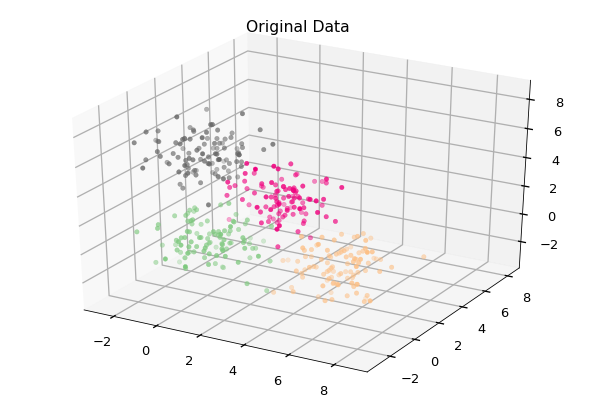

In [9]:
do_plot(X.values, 'Original Data', y)

## Dumb 2D projection
The easiest way to embed our data into two dimensions is to project onto the plane $x=0$.

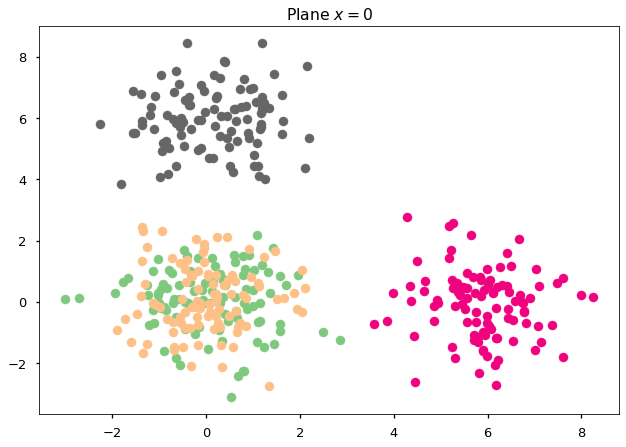

In [12]:
do_plot(X.values[:,1:], 'Plane $x=0$', labels)

## PCA (2D)

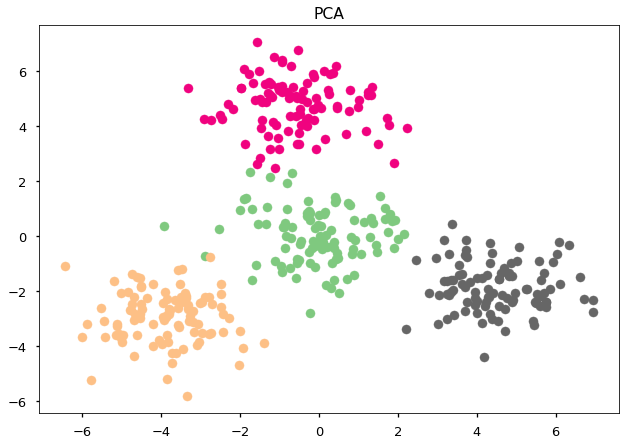

In [13]:
do_plot(PCA(n_components=2).fit_transform(X), 'PCA', labels)

## Isomap

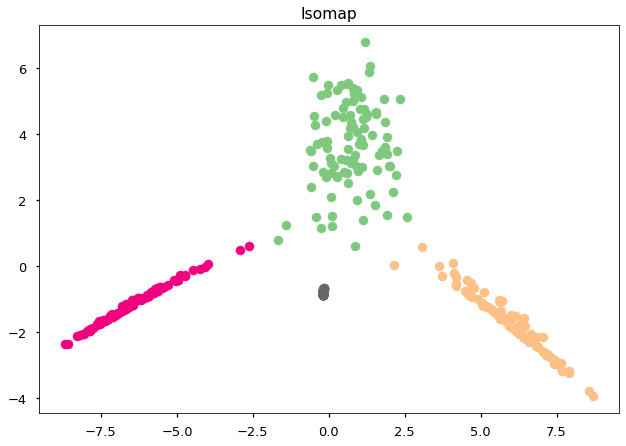

In [14]:
do_plot(Isomap(n_components=2).fit_transform(X), 'Isomap', labels)

## Locally Linear Embedding

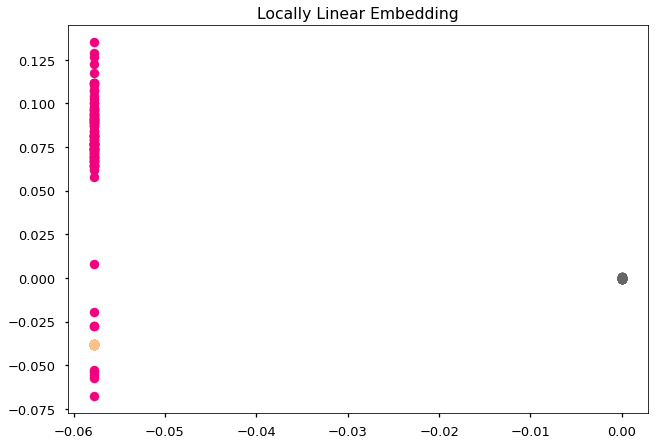

In [16]:
do_plot(LocallyLinearEmbedding(n_components=2).fit_transform(X), 'Locally Linear Embedding', labels)

## Spectral Embedding

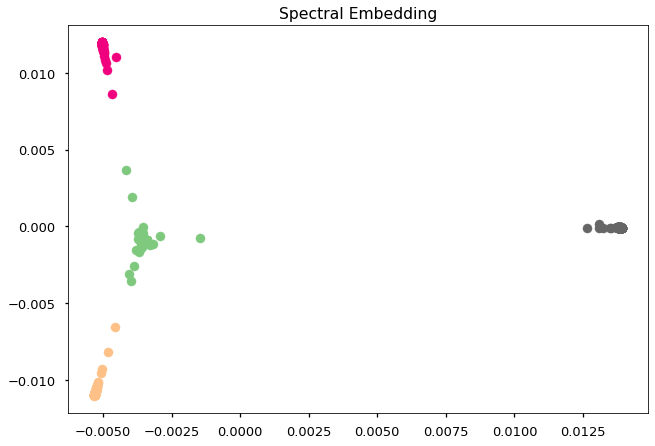

In [17]:
do_plot(SpectralEmbedding(n_components=2).fit_transform(X), 'Spectral Embedding', labels)

## Multi-dimensional scaling (MDS)

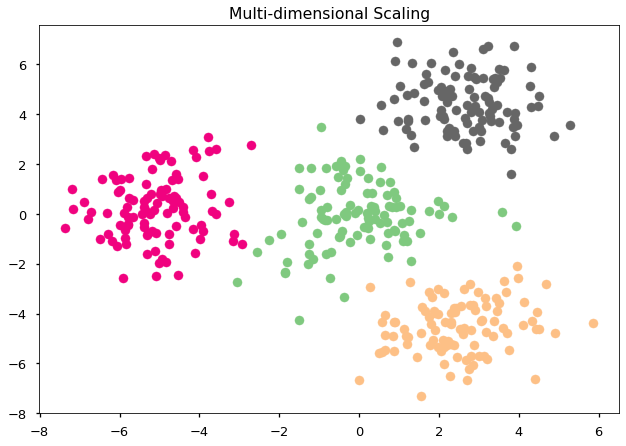

In [18]:
do_plot(MDS(n_components=2).fit_transform(X), 'Multi-dimensional Scaling', labels)

## t-SNE (2D)

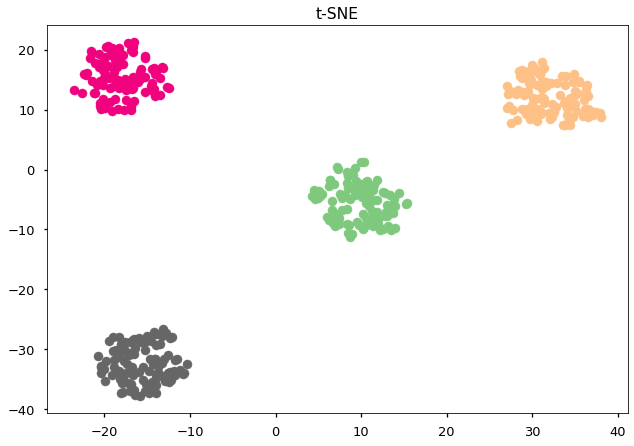

In [19]:
tsne2 = TSNE(n_components=2, random_state=0)
do_plot(tsne2.fit_transform(X), 't-SNE', labels)

## PCA (3D)

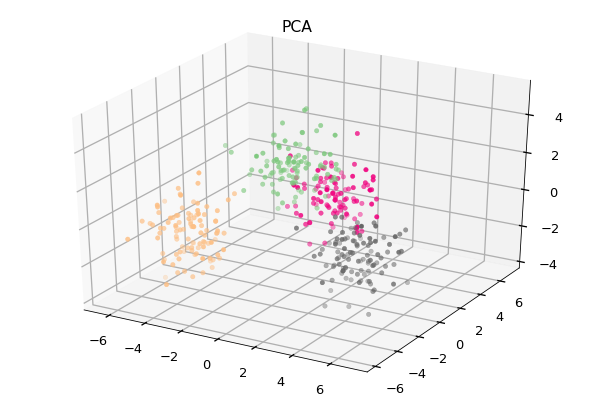

In [20]:
do_plot(PCA(n_components=3).fit_transform(X), 'PCA', labels)

## t-SNE (3D)

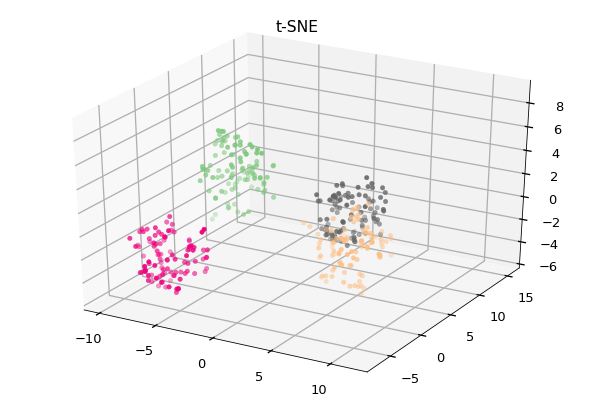

In [21]:
tsne3 = TSNE(n_components=3, learning_rate=100, random_state=0)
do_plot(tsne3.fit_transform(X), 't-SNE', labels)

## HDBScan
HDBScan is a fairly recent and well-regarded clustering algorithm. The reason it's here is to see how well it does on some fairly simple data and visualize its results via t-SNE.

In [22]:
if hdbscan_available:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
    cluster_labels = clusterer.fit_predict(X_std) + 1
    print('Number of clusters: {}'.format(max(cluster_labels)))
    do_plot(tsne3.fit_transform(X), 'HDBScan', labels=cluster_labels)

# UMAP
Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. 

In [ ]:
if umap_available:
    embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)
    embedding = umap.UMAP().fit_transform(X)
    do_plot(embedding, 'UMAP', labels)